# This file is used for neural field simulation for SEEG stimulation

In [1]:
'''
Stimulation using neural fields and forward solution
'''

from tvb.simulator.lab import *
from tvb.basic.readers import ZipReader
from tvb.datatypes.sensors import SensorsInternal
from tvb.datatypes.projections import ProjectionSurfaceSEEG

import numpy as np
import matplotlib.pyplot as plt
import os.path as op


In [2]:
pip install mne

     |████████████████████████████████| 7.4 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 4.2 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append('/root/capsule/code/util')
from utils_simulate import CorticalSurface_new, LocalConnectivity_new, LaplaceKernel, SpatEpi
from utils_simulate import zero_columns, zero_rows
from utils_model import Spat3DEpi
from utils_integrator import HeunDeterministicAdapted
from gain_matrix_seeg import bipify_gain
#sys.path.append('/Users/dollomab/MyProjects/Epinov_trial/vep_run_Trial/fit/')
from vep_prepare_sim import read_seeg_xyz

In [4]:
from utils_model4 import SpatEpiStim
from utils_simulate import CorticalSurface_new, LocalConnectivity_new, LaplaceKernel, SpatEpi, Heaviside

In [5]:
local_con_scaling = 0.9
global_con_scaling = 0.1
EZ = 'Left-F1-lateral-prefrontal'

In [6]:
pid = 'Patient2'

In [7]:
subject_dir = f'/data/ana/vep/'
data_dir = f'{subject_dir}/tvb/'

In [8]:
# Initialise a Connectivity
print("Setup long range connectivity")
con = connectivity.Connectivity.from_file(str(data_dir + 'connectivity.vep.zip'))
con.weights = np.log(con.weights+1)
con.weights /= con.weights.max()
con.speed = np.array([6])
con.configure()

Setup long range connectivity
2025-03-05 23:00:34,816 - WARNING - tvb.basic.readers - File 'average_orientations' not found in ZIP.
2025-03-05 23:00:34,817 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2025-03-05 23:00:34,818 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


In [9]:
np.shape(con.weights)

(163, 163)

In [10]:
print("Setup local connectivity")
res = '_ico5'
surf = cortex.Cortex.from_file(source_file= str(data_dir + ("/Cortex_pial"+res+".zip")),
                                region_mapping_file=str(data_dir + ("/Cortex_region_map"+res+".txt")))
surf.region_mapping_data.connectivity = con
loc_conn = LocalConnectivity_new(equation=LaplaceKernel(), cutoff=10.0)
loc_conn.equation.parameters['b'] = 1
loc_conn.equation.parameters['amp'] = local_con_scaling
cort_surf = CorticalSurface_new.from_file(source_file=str(data_dir + ("/Cortex_pial"+res+".zip")))
cort_surf.configure()
loc_conn.surface = cort_surf

print("Configure cortical surface")
surf.local_connectivity = loc_conn
surf.configure()

Setup local connectivity
Configure cortical surface


In [11]:
# set corpus callosum/ medial wall vertices to 0 in local connectivity
roi = con.region_labels
csr_mat = surf.local_connectivity.matrix
csr_mat = zero_columns(csr_mat, np.where(surf.region_mapping == 0)[0])
csr_mat = zero_rows(csr_mat, np.where(surf.region_mapping == 0)[0])
idx_con = np.where(roi == EZ)[0][0]  # idx in the connectivity matrix for that region
col_index = np.where(surf.region_mapping == idx_con)[0]
csr_mat[np.ix_(col_index,col_index)] = csr_mat[np.ix_(col_index,col_index)]

csr_mat.eliminate_zeros()
surf.local_connectivity.matrix = csr_mat

In [12]:
# Create a regionmap as will be used in the simulator later, in order to set parameters for subcortical structures
_regmap = np.r_[surf.region_mapping, con.unmapped_indices(surf.region_mapping)]
assert len(_regmap) == len(surf.region_mapping_data.array_data) + len(
    con.unmapped_indices(surf.region_mapping_data.array_data)) # assertion _regmap = cortical + subcortical
idx_vertices = np.where(_regmap == idx_con)  # idx in the surface mesh vertices for that region

# Neural mass model
k = 0.318
g11 = 0.5334
g22 = 1.0

epileptors = SpatEpiStim()
epileptors.variables_of_interest = ('u1', 'q1', 's', 'm')
epileptors.gamma11 = np.array([k * g11])
epileptors.gamma12 = np.array([k * 0.1])
epileptors.gamma22 = np.array([k * g22])
epileptors.theta11 = np.array([-1.0])
epileptors.theta12 = np.array([-1.0])
epileptors.theta22 = np.array([-0.5])
epileptors.Iext = np.array([3.1])
# epileptors.r = np.array([0.0005])#0.0008])
epileptors.Iext2 = np.array([0.45])
epileptors.tau2 = np.array([10.0])
epileptors.tt = np.array([0.17])

epileptors.tau0 = np.array([1000.0])  # timescale of z
epileptors.tau3 = np.array([600.0])  # timescale of m

n_nodes = surf.vertices.shape[0] + sum(np.invert(con.cortical))  # number of vertices + subcortical regions
epileptors.x0 = np.ones((n_nodes)) * (-3.5)
epileptors.threshold = np.ones((n_nodes)) * (100.0)
epileptors.Istim = np.ones((n_nodes)) * (0.)

epileptors.x0[idx_vertices] = -2.2  # setting this region close to criticality
epileptors.threshold[idx_vertices] = 1.8

'''

epileptors = SpatEpiStim()#Spat7DEpi()
epileptors.variables_of_interest = ('u1', 'q1', 's', 'm')#('x1', 'x2', 'z', 'm')
epileptors.gamma11 = np.array([k*g11])
epileptors.gamma12 = np.array([k*0.1])
epileptors.gamma22 = np.array([k*g22])
epileptors.theta11 = np.array([-1.0])
epileptors.theta12 = np.array([-1.0])
epileptors.theta22 = np.array([-0.5])
epileptors.Iext   = np.array([3.1])
epileptors.Iext2   = np.array([0.45])
epileptors.tau2    = np.array([10.0])
epileptors.tt      = np.array([0.17])
# epileptors.r = np.array([0.0015])
# epileptors.r2 = np.array([0.0022])
epileptors.tau0 = np.array([715])
epileptors.tau3 = np.array([455])

n_nodes = surf.vertices.shape[0] + sum(np.invert(con.cortical)) # number of vertices + subcortical regions
epileptors.x0      = np.ones((n_nodes)) * (-2.5)
epileptors.threshold = np.ones((n_nodes)) * (10.0)

# new variables for 3D Epileptor:
epileptors.Istim  = np.ones((n_nodes)) * (0.)
# epileptors.n_stim = np.ones((n_nodes)) #* 0
'''
# Create a regionmap as will be used in the simulator later, in order to set parameters for subcortical structures
_regmap  = np.r_[surf.region_mapping, con.unmapped_indices(surf.region_mapping)]

In [13]:
# Load SEEG sensors
seeg_names   = np.genfromtxt(str(subject_dir + "/elec/seeg.xyz"), usecols=0, dtype=str)
seeg_coord   = np.genfromtxt(str(subject_dir + "/elec/seeg.xyz"), usecols=[1,2,3], dtype=float)
seeg_sensors = SensorsInternal(locations = seeg_coord, labels=seeg_names)
seeg_sensors.configure()

In [14]:
# Load gain matrix and average gain across subcortical vertices,
# because they are stil represented as a single neural mass model in TVB
gain_type = "gain_dipole"  # "gain_inv_square" or "gain_dipole" or "gain_openmeeg_bem"
gain_mat = np.load(str(data_dir + '/' + (gain_type + res + ".npz")))[gain_type]
gain_region_map = np.genfromtxt(str(data_dir + ("/gain_region_map" + res + ".txt")))


In [15]:
# Correcting gain matrix Unknown region such as to not take it into account
gain_mat[:, gain_region_map == 0] = 0

gain_mat_new = np.zeros((seeg_sensors.number_of_sensors, len(_regmap)))
n_cort_vert = len(surf.region_mapping)
gain_mat_new[:, :n_cort_vert] = gain_mat[:, :n_cort_vert]

# Loop across subcortical structures and average
for rm_idx, SC_idx in enumerate(con.unmapped_indices(surf.region_mapping)):
    gain_mat_new[:, n_cort_vert + rm_idx] = gain_mat[:, gain_region_map == SC_idx].sum(axis=1)
# np.savez_compressed(str(data_dir/"gain_tvb.npz"), gain_tvb=gain_mat_new)
seeg_proj = ProjectionSurfaceSEEG(sensors=seeg_sensors, projection_data=gain_mat_new)


In [16]:
seeg_proj

In [17]:
# Stimulation
channel = "PM'3-4"
choi1 = np.where(seeg_names == "PM'3")[0]
choi2 = np.where(seeg_names == "PM'4")[0]
gain_signal = abs(gain_mat_new[choi2] - gain_mat_new[choi1])
gain_signal = np.squeeze(gain_signal)

In [18]:
max_roi = np.where(gain_signal == max(gain_signal))[0][0]
# So the good region mapping to use here is _regmap, cause we now have computed subcortical regions as nodes
# So subcortical regions can only be extracted from this _regmap since we are using gain_mat_new
print('The label corresponding to the highest value : ', con.region_labels[_regmap[max_roi]])

# Getting N highest values from the gain matrix
n = 20
n_max_roi = np.argsort(gain_signal)[-n:]
print('The labels corresponding to the highest values : ', con.region_labels[_regmap[n_max_roi]])


The label corresponding to the highest value :  Left-F1-mesial-prefrontal
The labels corresponding to the highest values :  ['Left-F1-lateral-prefrontal' 'Left-Anterior-cingulate-cortex'
 'Left-SFS-rostral' 'Left-F1-mesial-prefrontal'
 'Left-F1-lateral-prefrontal' 'Left-F1-mesial-prefrontal'
 'Left-F1-mesial-prefrontal' 'Left-F1-lateral-prefrontal'
 'Right-F1-mesial-prefrontal' 'Left-F1-mesial-prefrontal'
 'Left-F1-lateral-prefrontal' 'Left-F2-rostral' 'Left-SFS-rostral'
 'Left-F1-mesial-prefrontal' 'Left-F1-mesial-prefrontal'
 'Left-F1-lateral-prefrontal' 'Left-F1-mesial-prefrontal'
 'Left-F1-mesial-prefrontal' 'Left-F1-mesial-prefrontal'
 'Left-F1-mesial-prefrontal']


In [19]:
# stimulus parameters
freq = 50  # Hz
T = 1. / freq * 1000.  # pulse repetition period [ms]
tau = 2 # pulse duration [ms]
I = 3 #stim_amplitude # pulse intensity [mA]
onset = 20 #500  # [ms]
stim_length = 35# 3500  # [ms]
simulation_length = 100#15000#35000  # [ms]
dt = 0.2

In [20]:
class vector1D(equations.DiscreteEquation):
        equation = equations.Final(default="emp")
eqn_t = vector1D()
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse1_ts = [p[1] for p in pulse1]
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse2_ts = [p[1] for p in pulse2]

pulse_ts = np.asarray(pulse1_ts) - np.asarray(pulse2_ts)
stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)  # np.random.random_sample((2000,1))

# stim_weights = gain_signal
stim_weights = np.zeros(n_nodes)

In [21]:
for i in range(con.region_labels.size):
    stim_weights[i] = gain_signal[np.where(_regmap == i)].max()

In [22]:
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                      connectivity=con,
                                      weight=stim_weights)
stimulus.configure_space(region_mapping=_regmap)
stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

In [24]:
# Integrator
heunint = HeunDeterministicAdapted(dt=dt)

# Monitors
mons = [monitors.TemporalAverage(period=10.),
        monitors.SpatialAverage(period=10., spatial_mask = _regmap)]

# Global connectivity
# coupl = coupling.Difference(a=np.array([global_con_scaling]))
coupl = Heaviside(a=np.array([global_con_scaling]), theta=np.array([-1]))

# Initial conditions
ic = [-1.6242601e+00, -16.69344913e+00, 4.1, -1.11181819e+00, -9.56105974e-20, -4.38727802e-01, 0]
ic_full = np.repeat(ic, n_nodes).reshape((len(ic), n_nodes, 1))

# Simulator
sim = simulator.Simulator(model=epileptors,
                        stimulus=stimulus,
                        connectivity=con,
                        coupling=coupl,
                        integrator=heunint,
                        monitors=mons,
                        surface=surf)
sim.configure()
sim.current_state = ic_full

# Run
print("Run Simulation !")
#tic = tm.time()
simulation_length = 100
results = sim.run(simulation_length=simulation_length)
#print(f"Simulation length : {(tm.time()-tic)/60.} min.")

# Save results
(t, data_tavg), (t, data_savg) = results

2025-03-05 23:02:46,724 - WARNING - tvb.simulator.simulator - Memory estimate exceeds total available RAM.
Run Simulation !
2025-03-05 23:02:46,728 - WARNING - utils_integrator - random_state supplied for non-stochastic integration


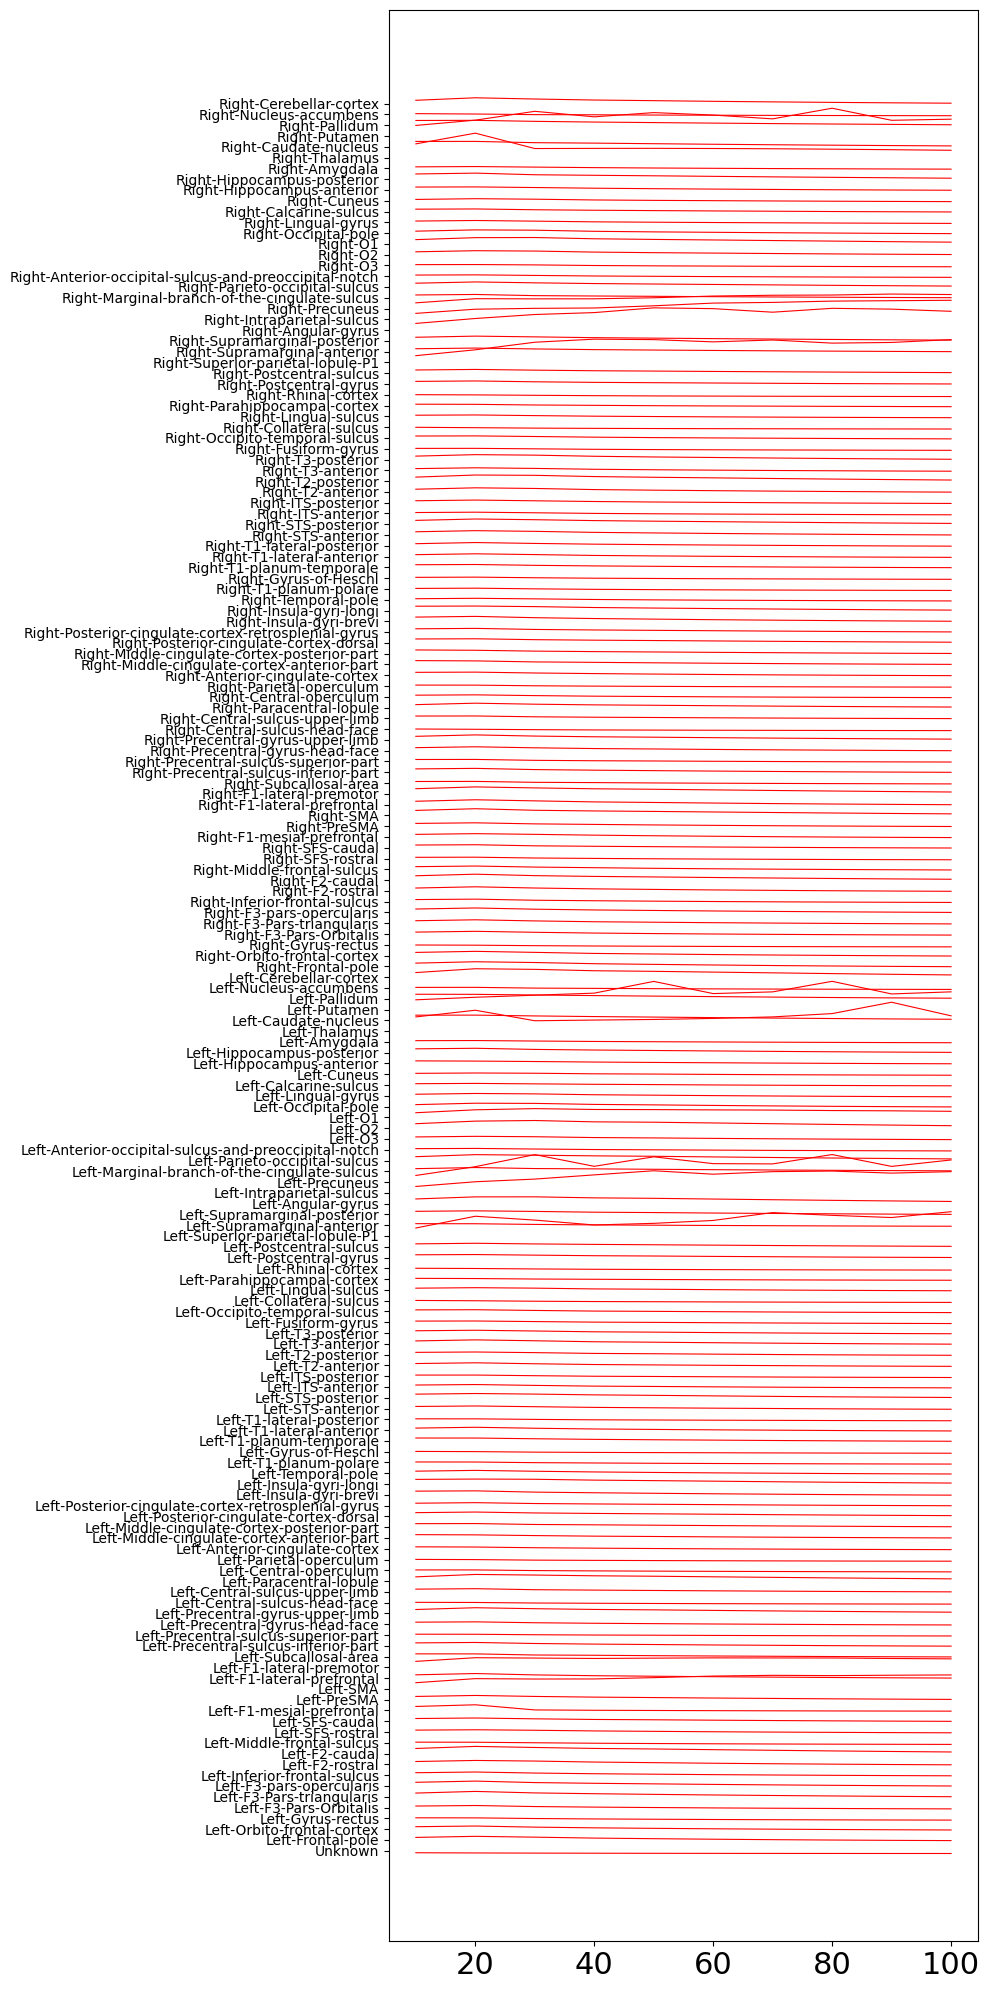

In [25]:
%matplotlib inline 
plot_data = True
if plot_data :
    # plot data
    roi = con.region_labels
    srcSig = data_savg[:, 0, :, 0]-data_savg[:, 1, :, 0]
    # srcSig_normal = srcSig/np.ptp(srcSig)

    # Plot raw time series
    fig = plt.figure(tight_layout=True, figsize=(10, 20))
    plt.plot(t, srcSig + np.r_[:len(roi)]+0.5, 'r', linewidth=0.8)
    plt.yticks(np.arange(len(roi)), roi, fontsize=10)

    plt.xticks(fontsize=22)

In [26]:
save_res = False
if save_res :
    # saving sensor data and source data
    save_sim_data = f'/results/'

    # save the generated data on the source level
    end = 750 # to crop the simulated time series before their end
    print(f'Saving simulated_source_data_glob_scal_{global_con_scaling}_loc_scal_{local_con_scaling}_SEEG')
    np.savez(f'{save_sim_data}/simulated_source_data_glob_scal_{global_con_scaling}_loc_scal_{local_con_scaling}_SEEG',
             time_steps=t[:end], tavg=data_tavg[:end, :,:,:], savg=data_savg[:end, :,:,:], I=I)
    np.savez(f'{save_sim_data}/simulated_source_data_glob_scal_{global_con_scaling}_loc_scal_{local_con_scaling}_SEEG_sti', stim_weights=stimulus.spatial_pattern)
